# ABC Data Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('talk')

import networkx as nx

## 1 Chord Symbols

### 1.1 n-grams

In [2]:
df = pd.read_csv('data/all_annotations.tsv', sep='\t')

In [3]:
df.head()

,chord,altchord,measure,beat,totbeat,timesig,op,no,mov,length,global_key,local_key,pedal,numeral,form,figbass,changes,relativeroot,phraseend
0,.Eb.I,NaN,1,1.0,1.0,2/4,127,12,1,2.5,Eb,I,NaN,I,NaN,NaN,NaN,NaN,False
1,V43,NaN,2,1.5,3.5,2/4,127,12,1,1.5,Eb,I,NaN,V,NaN,43.0,NaN,NaN,False
2,I,NaN,3,1.0,5.0,2/4,127,12,1,2.5,Eb,I,NaN,I,NaN,NaN,NaN,NaN,False
3,V2,NaN,4,1.5,7.5,2/4,127,12,1,1.5,Eb,I,NaN,V,NaN,2.0,NaN,NaN,False
4,I6,NaN,5,1.0,9.0,2/4,127,12,1,1.0,Eb,I,NaN,I,NaN,6.0,NaN,NaN,False


Somehow the `figbass` feature was exported as float, so it is transformed into `str`.

In [4]:
df['figbass_str'] = df['figbass'].fillna('').astype(str).str.replace('.0', '')

We create a new column that contains the tokens that will be the basis for the analysis. A token consists of a combination of parts of the chord symbol.

In [5]:
tokens = [
    'numeral',
    'form',
    'figbass_str',
#     'changes',
#     'relativeroot',
#     'phraseend'
]

In [6]:
df['token'] = ''

for token in tokens:
    s = df[token].fillna('')
    df['token'] += s.values.astype(str)

In [7]:
df.token.unique(), len(df.token.unique())

(array(['I', 'V43', 'V2', 'I6', 'vi', 'IV', 'ii6', 'vi64', 'ii7', 'III',
        'V', 'V7', 'ii43', 'V65', 'IV2', 'I+6', 'I64', 'iiio6', 'III7',
        'II65', '#vo7', 'vii%7', '#iv%7', 'V64', 'ii', 'i', 'v6', 'II64',
        'v', 'iv', 'II6', 'i6', 'i64', 'iio64', 'iio6', '#viio2',
        '#viio43', 'ii%7', 'IV64', 'II2', 'II43', 'V6', 'iv6', 'II7',
        'vii%43', 'I7', 'IV6', 'I2', 'VII', 'I43', 'iv64', 'i2', 'IV65',
        'bIII7', 'bVI', 'bIII2', 'vio65', 'vio43', 'bvii6', 'bII7',
        'iiio2', 'iiio65', 'iiio43', 'iiio7', 'vo65', 'vo2', 'bVI64',
        'bVI6', 'bVII2', 'viio43', 'ii65', 'ii64', 'I65', 'IV43', 'bVII',
        '#io7', 'VI64', 'viio2', 'IV+', '#ivo7', '#ivo', 'viio64', 'viio7',
        'vi6', 'ivo', 'viio6', 'vi2', '#viio6', 'vi7', 'ii2', 'viio',
        '#viio7', '#viio', 'V+6', 'bII6', '#ivo2', 'viio65', 'iiio64',
        'Ger6', 'VI', '#io64', 'iiio', '#vo2', 'Fr6', '#viio65', 'ii%65',
        'vi65', '#vio65', '#vi65', 'v43', '#vo43', 'vi43', '#V', '',


Some of the analysis will be performed separately for each movement. We group the data according to opus, number, and movement.

In [8]:
grouped = df.groupby(['op', 'no', 'mov'])

In [9]:
def get_ngrams(matrix, n):
    ngrams = matrix[0:n, n-1:]
    
    ngram_list = [ngrams[:,i][::-1] for i in range(ngrams.shape[1])]
    
    return ngram_list

In [10]:
unigrams = df.token.value_counts()

The unigram token counts for the 40 most common tokens are:

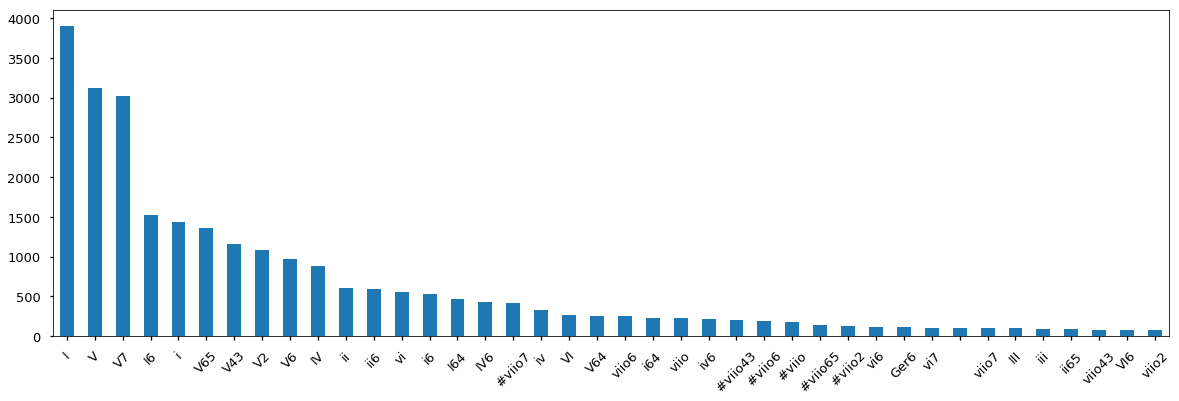

In [11]:
unigrams[:40].plot.bar(figsize=(20,6), rot=45);

In [12]:
bigrams = []
trigrams = []

for index, group in grouped:
    group = group.reset_index()
    
    # initialize ngram matrix
    matrix = np.zeros((len(group), len(group)), dtype='object')
    
    # fill matrix
    matrix[0, :] = group['token'].values
    for i in range(1,len(group)):
        matrix[i, i:] = group['token'][:-i]
        
    bigrams.append(get_ngrams(matrix, 2))
    trigrams.append(get_ngrams(matrix, 3))

### 1.2 Transition table for bigrams

In [13]:
bigram_counts = pd.DataFrame(0,index=unigrams.index, columns=unigrams.index)

In [14]:
for bg_list in bigrams:
    for bg in bg_list:
        bigram_counts.loc[bg[0], bg[1]] += 1

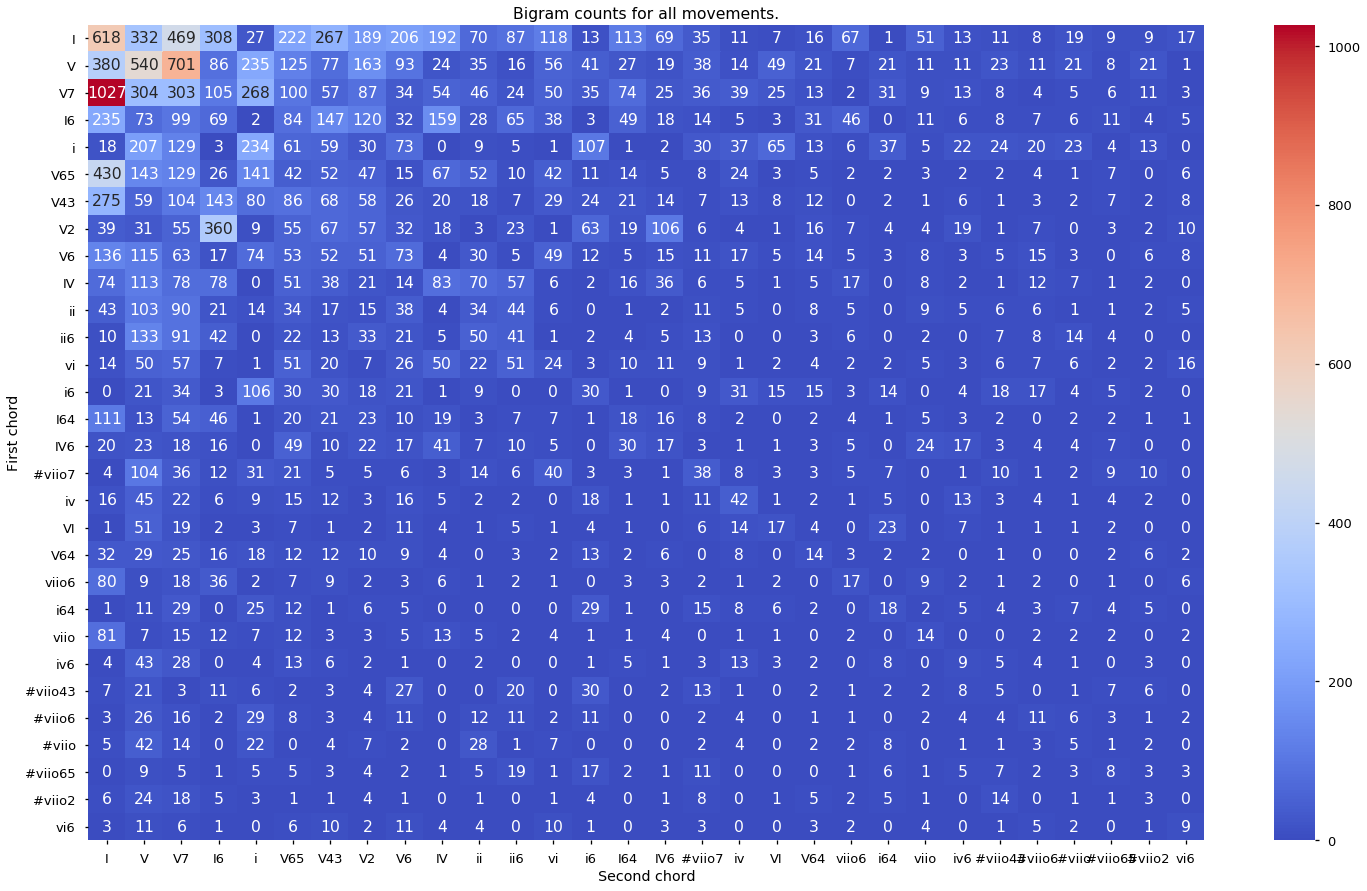

In [15]:
plt.figure(figsize=(25,15))
plt.title('Bigram counts for all movements.')
sns.heatmap(bigram_counts.iloc[:30, :30], 
            cmap='coolwarm', 
            annot=True, 
            fmt='.0f');
plt.ylabel('First chord')
plt.xlabel('Second chord')
plt.xticks(rotation=0);
plt.savefig('img/bigram_counts.png')

### 1.3 Bigram Entropy

We now inspect the marginal distributions.

In [16]:
bigram_counts.head()

,I,V,V7,I6,i,V65,V43,V2,V6,IV,...,bv64,bVI7,ii%,vi%2,iii%43,V+64,#vi7,vo6,VII65,ivo64
I,618,332,469,308,27,222,267,189,206,192,...,0,0,0,0,0,1,0,0,0,0
V,380,540,701,86,235,125,77,163,93,24,...,0,0,0,0,0,0,0,0,0,0
V7,1027,304,303,105,268,100,57,87,34,54,...,0,0,0,0,0,0,0,0,0,1
I6,235,73,99,69,2,84,147,120,32,159,...,0,0,0,0,0,0,0,0,0,0
i,18,207,129,3,234,61,59,30,73,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
normalized_bigrams = bigram_counts.div(bigram_counts.sum(axis=1), axis=0)
normalized_bigrams.head()

,I,V,V7,I6,i,V65,V43,V2,V6,IV,...,bv64,bVI7,ii%,vi%2,iii%43,V+64,#vi7,vo6,VII65,ivo64
I,0.160021,0.085966,0.121440,0.079751,0.006991,0.057483,0.069135,0.048938,0.053340,0.049715,...,0.0,0.0,0.0,0.0,0.0,0.000259,0.000000,0.0,0.0,0.000000
V,0.122147,0.173578,0.225329,0.027644,0.075538,0.040180,0.024751,0.052395,0.029894,0.007715,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
V7,0.340179,0.100696,0.100364,0.034780,0.088771,0.033124,0.018880,0.028817,0.011262,0.017887,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000331
I6,0.154301,0.047932,0.065003,0.045305,0.001313,0.055154,0.096520,0.078792,0.021011,0.104399,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
i,0.012614,0.145060,0.090399,0.002102,0.163980,0.042747,0.041345,0.021023,0.051156,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000701,0.0,0.0,0.000000


In [18]:
from scipy.stats import entropy

### 1.4 Plot marginal distributions for interesting chords

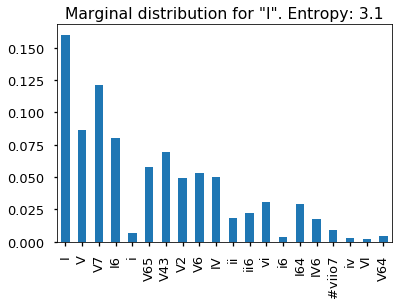

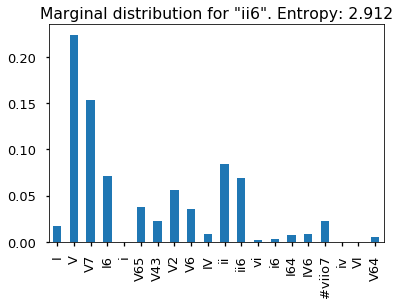

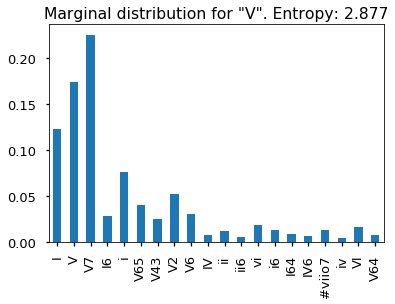

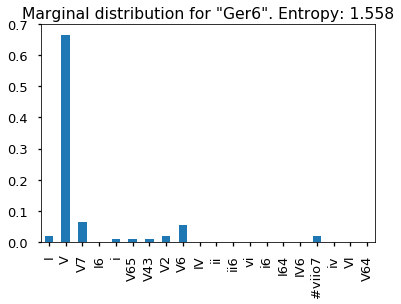

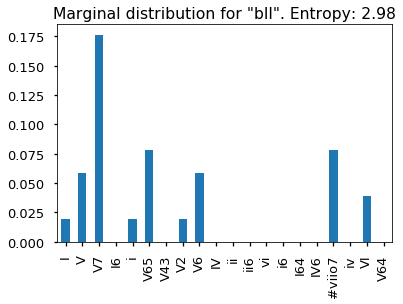

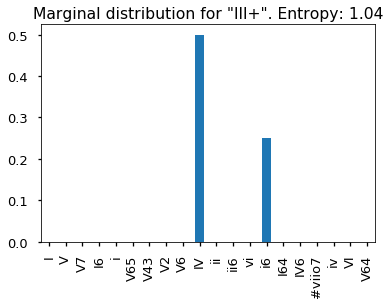

In [19]:
chords = ['I', 'ii6', 'V', 'Ger6', 'bII', 'III+']

for chord in chords:
    marginal = normalized_bigrams.loc[chord]
    H = round(entropy(marginal), 3)
    plt.figure()
    plt.title(f'Marginal distribution for \"{chord}\". Entropy: {H}')
    normalized_bigrams.loc[chord][:20].plot(kind='bar');
    plt.savefig(f'img/marginal_{chord}.png')

### 1.5 Plot entropies for all chords

In [20]:
entropies = {}
for u in unigrams.index:
    H = entropy(bigram_counts.loc[u,:])
    entropies[u] = H

In [21]:
entropies = pd.Series(entropies)

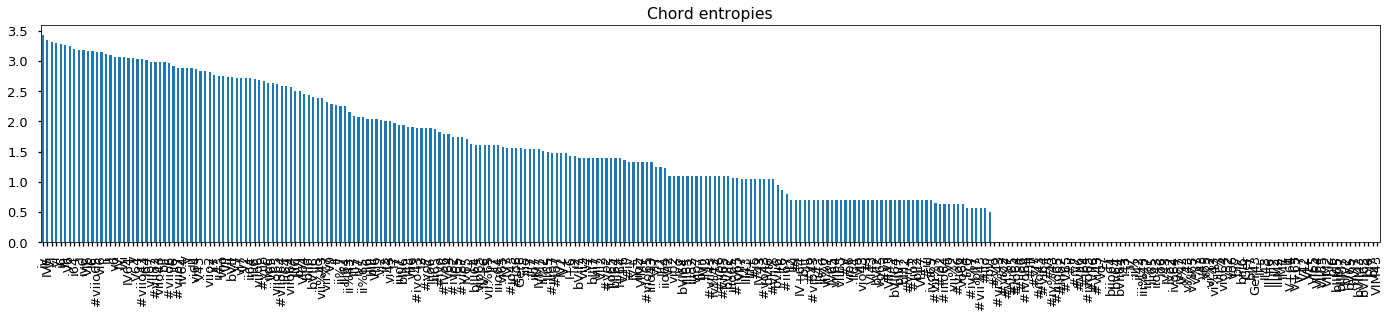

In [22]:
entropies.sort_values(ascending=False).plot(kind='bar', figsize=(24,4));
plt.title('Chord entropies')
plt.savefig('img/entropies.png')

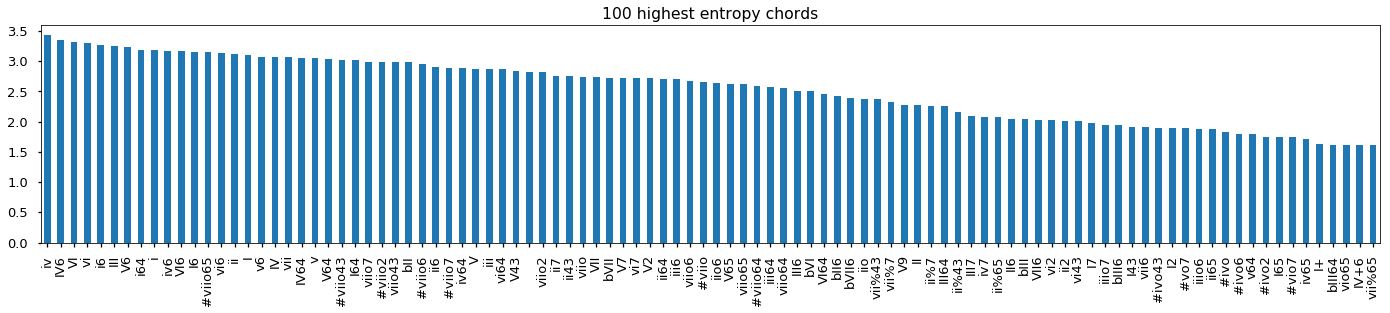

In [23]:
entropies.sort_values(ascending=False)[:100].plot(kind='bar', figsize=(24,4));
plt.title('100 highest entropy chords')
plt.savefig('img/entropies_highest.png')

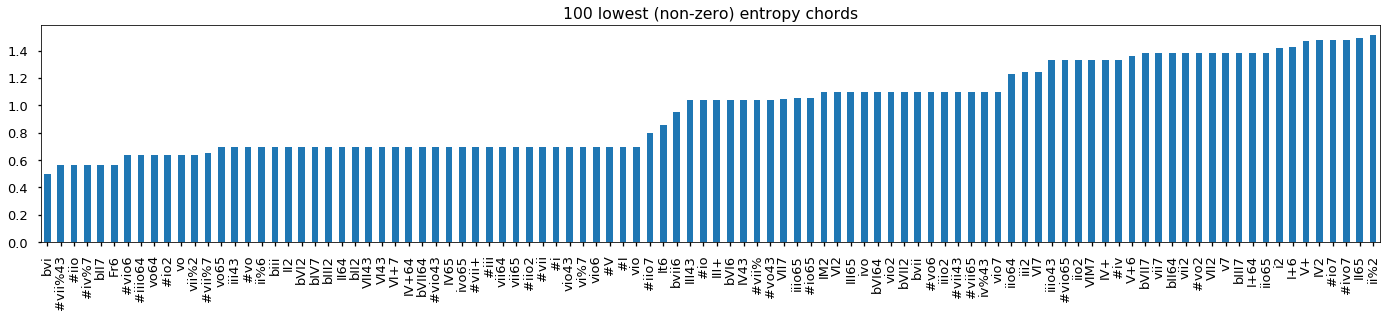

In [24]:
entropies[entropies !=0].sort_values(ascending=True)[:100].plot(kind='bar', figsize=(24,4));
plt.title('100 lowest (non-zero) entropy chords')
plt.savefig('img/entropies_lowest.png')

### 1.6 Calculate KL Divergence for all pairs of marginals

In [25]:
KL = pd.DataFrame(0,index=unigrams.index, columns=unigrams.index)

In [26]:
for index1, row1 in normalized_bigrams.iterrows():
    for index2, row2 in normalized_bigrams.iterrows():
        KL.loc[index1, index2] += entropy(row1,row2)

In [27]:
KL.head(10)

,I,V,V7,I6,i,V65,V43,V2,V6,IV,...,bv64,bVI7,ii%,vi%2,iii%43,V+64,#vi7,vo6,VII65,ivo64
I,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
V,inf,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
V7,inf,inf,0.000000,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
I6,inf,inf,inf,0.000000,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
i,inf,inf,inf,inf,0.000000,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
V65,inf,inf,inf,inf,inf,0.000000,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
V43,inf,inf,inf,inf,inf,inf,0.000000,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
V2,inf,inf,inf,inf,inf,inf,inf,0.000000,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
V6,inf,inf,inf,inf,inf,inf,inf,inf,0.000000,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
IV,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.000000,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


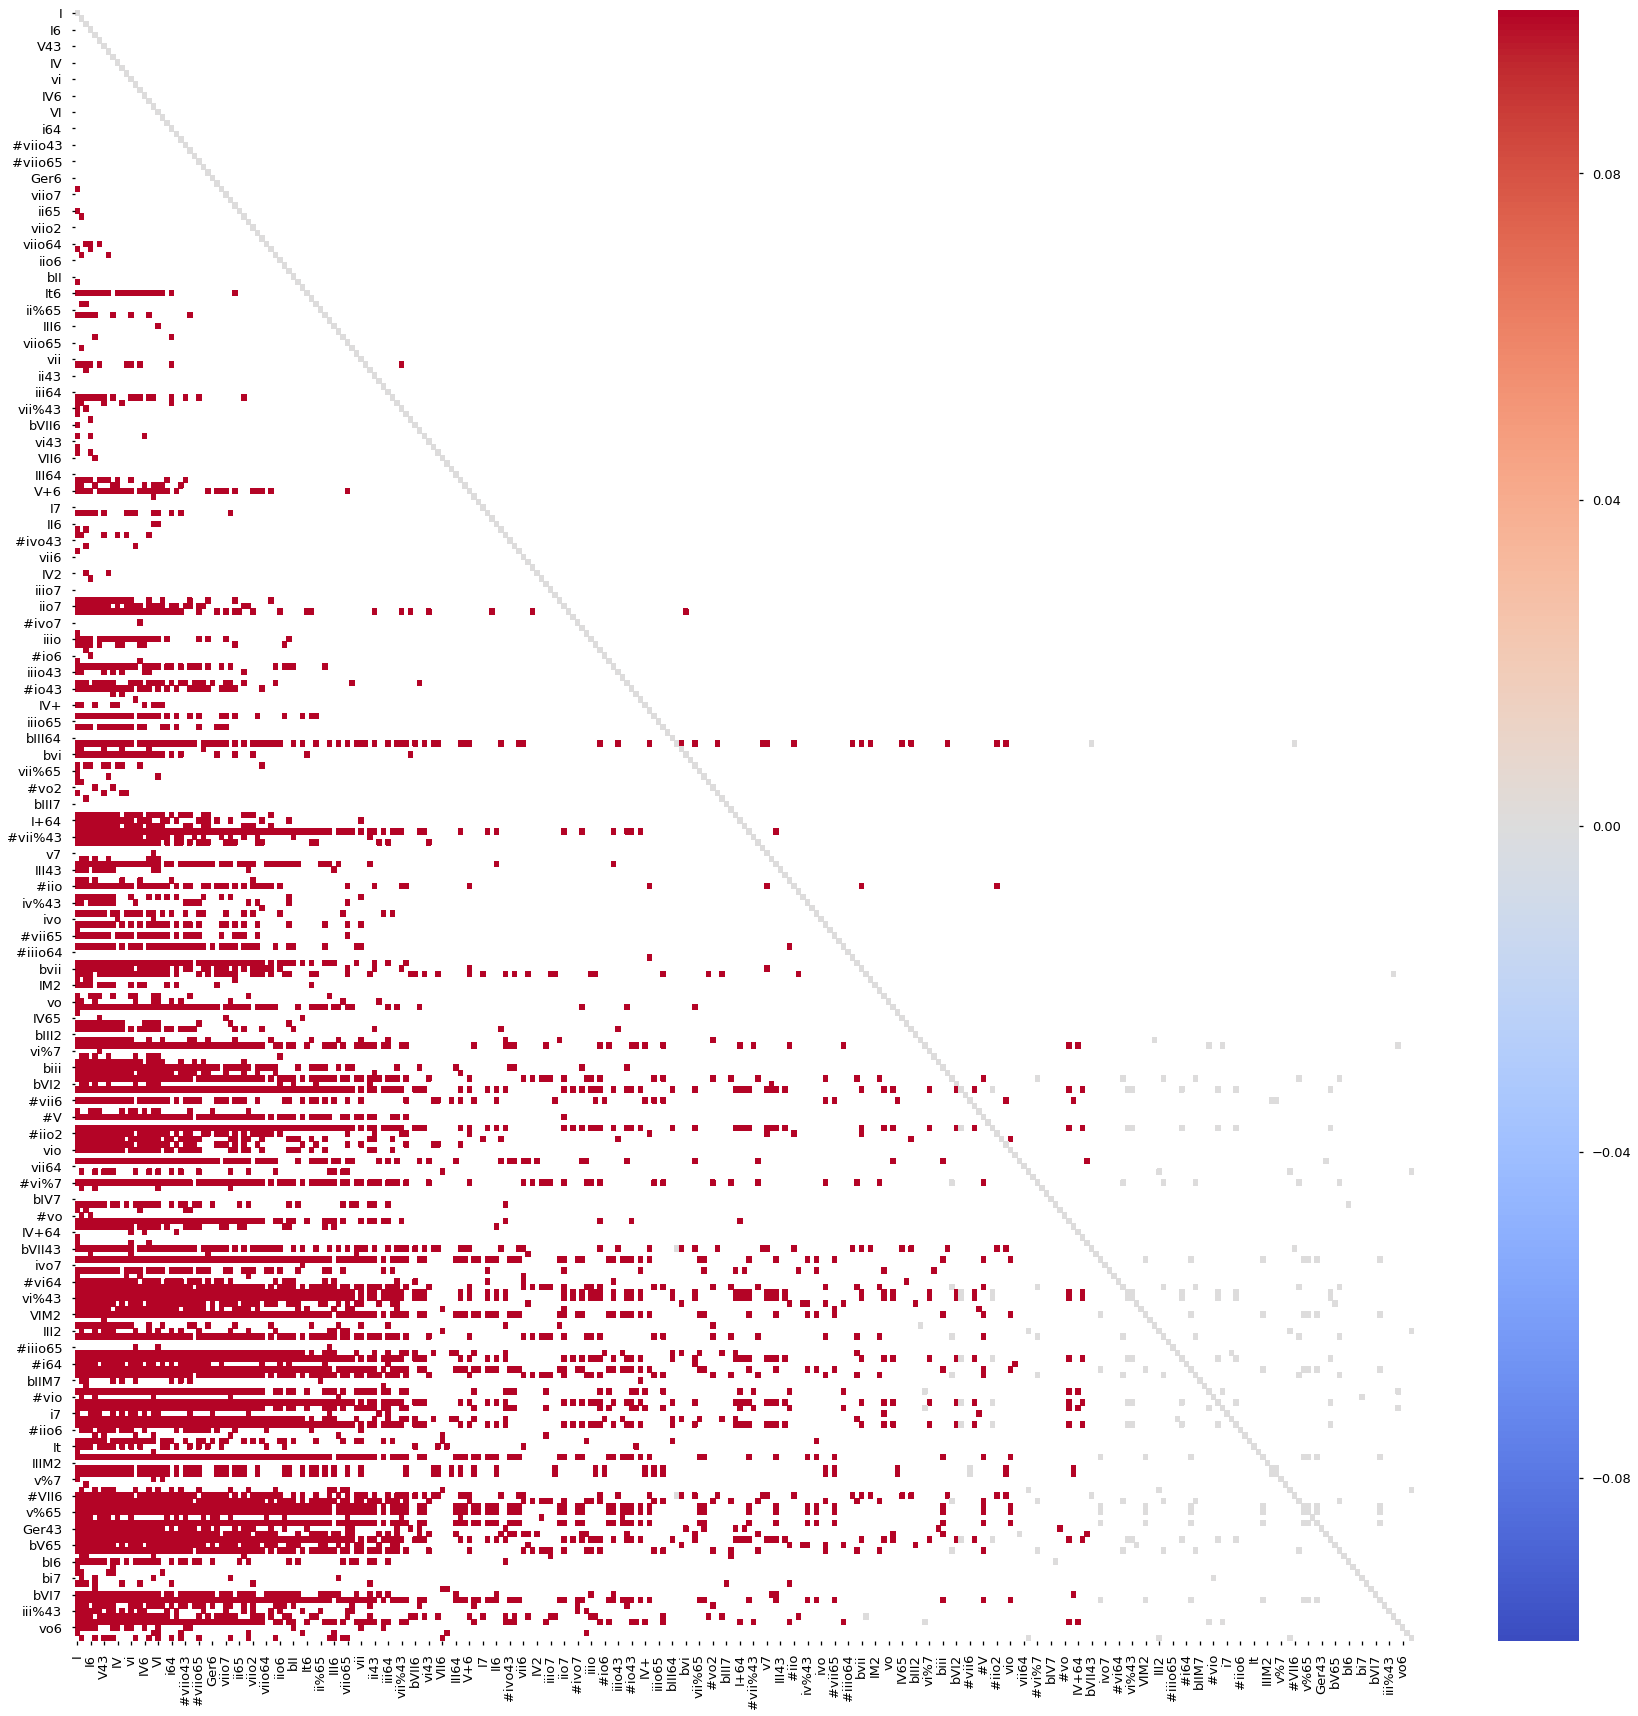

In [28]:
plt.figure(figsize=(30,30))
sns.heatmap(KL, cmap='coolwarm');
plt.savefig('img/KL_divergence.png')

### 1.7 Calculate correlations of all pairs of marginals

In [29]:
corr = pd.DataFrame(0,index=unigrams.index, columns=unigrams.index)

In [30]:
for index1, row1 in normalized_bigrams.iterrows():
    for index2, row2 in normalized_bigrams.iterrows():
        corr.loc[index1, index2] += np.correlate(row1,row2)

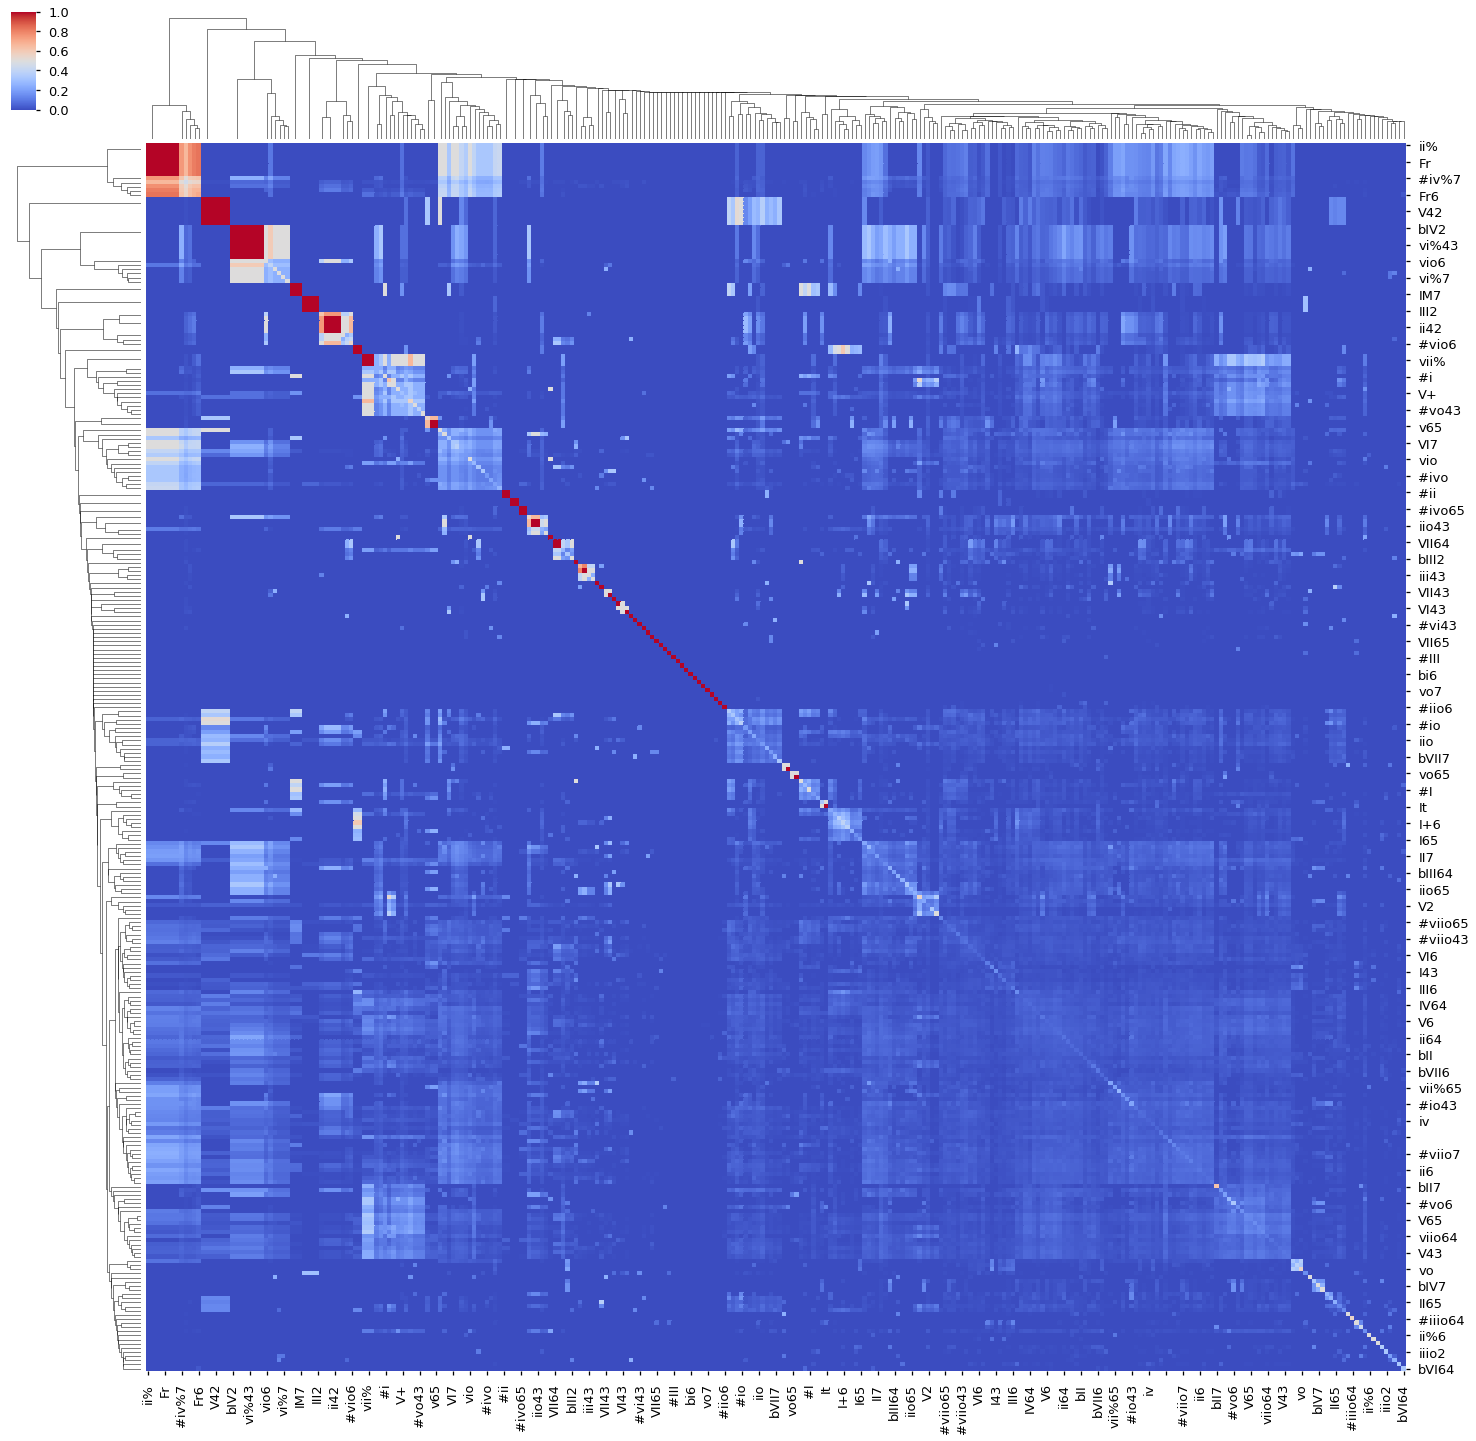

In [31]:
sns.clustermap(corr, cmap='coolwarm', figsize=(25,25));
plt.savefig('img/corr_clusters.png')

## 2 Keys

In [32]:
df.head()

,chord,altchord,measure,beat,totbeat,timesig,op,no,mov,length,...,local_key,pedal,numeral,form,figbass,changes,relativeroot,phraseend,figbass_str,token
0,.Eb.I,NaN,1,1.0,1.0,2/4,127,12,1,2.5,...,I,NaN,I,NaN,NaN,NaN,NaN,False,,I
1,V43,NaN,2,1.5,3.5,2/4,127,12,1,1.5,...,I,NaN,V,NaN,43.0,NaN,NaN,False,43,V43
2,I,NaN,3,1.0,5.0,2/4,127,12,1,2.5,...,I,NaN,I,NaN,NaN,NaN,NaN,False,,I
3,V2,NaN,4,1.5,7.5,2/4,127,12,1,1.5,...,I,NaN,V,NaN,2.0,NaN,NaN,False,2,V2
4,I6,NaN,5,1.0,9.0,2/4,127,12,1,1.0,...,I,NaN,I,NaN,6.0,NaN,NaN,False,6,I6


In [33]:
keys = df.local_key.value_counts(normalize=True)

In [34]:
keys

I       0.498748
i       0.134793
V       0.088252
IV      0.035988
v       0.031445
III     0.028368
vi      0.027331
VI      0.024576
iv      0.019425
iii     0.017672
bVI     0.015347
II      0.015204
bIII    0.014524
bVII    0.008550
ii      0.008120
bII     0.005581
vii     0.003398
bV      0.003220
VII     0.003148
#III    0.002933
#V      0.002111
#i      0.001538
#VI     0.001181
#iii    0.000966
#I      0.000930
#vii    0.000823
bvii    0.000823
#iv     0.000787
bIV     0.000644
biii    0.000501
bv      0.000501
#ii     0.000465
bii     0.000394
#II     0.000394
bI      0.000286
#IV     0.000286
a       0.000286
Ab      0.000250
bi      0.000143
#v      0.000072
Name: local_key, dtype: float64

### 2.2 Key bigrams

In [35]:
key_bigrams = []

for index, group in grouped:
    group = group.reset_index()
    
    # initialize ngram matrix
    matrix = np.zeros((len(group), len(group)), dtype='object')
    
    # fill matrix
    matrix[0, :] = group['local_key'].values
    for i in range(1,len(group)):
        matrix[i, i:] = group['local_key'][:-i]
        
    key_bigrams.append(get_ngrams(matrix, 2))

In [36]:
key_bigram_counts = pd.DataFrame(0,index=keys.index, columns=keys.index)

In [37]:
for bg_list in key_bigrams:
    for bg in bg_list:
        key_bigram_counts.loc[bg[0], bg[1]] += 1

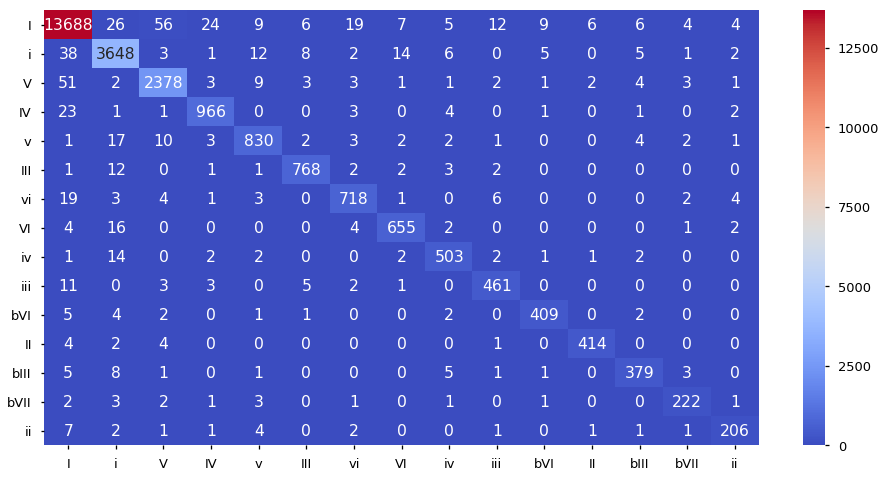

In [38]:
plt.figure(figsize=(16,8))
sns.heatmap(key_bigram_counts.iloc[:15, :15], 
            cmap='coolwarm', 
            annot=True,
            fmt='.0f'
           )
plt.yticks(rotation=0);
plt.savefig('img/key_bigrams_all.png')

In [39]:
normalized_key_bigrams = key_bigram_counts.div(key_bigram_counts.sum(axis=0), axis=1)

In [40]:
normalized_key_bigrams.head()

,I,i,V,IV,v,III,vi,VI,iv,iii,...,bv,#ii,bii,#II,bI,#IV,a,Ab,bi,#v
I,0.986736,0.006900,0.022700,0.023857,0.010239,0.007566,0.024869,0.010189,0.009208,0.024291,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000000,0.25,0.0
i,0.002739,0.968153,0.001216,0.000994,0.013652,0.010088,0.002618,0.020378,0.011050,0.000000,...,0.0,0.0,0.0,0.0,0.125,0.0,0.000,0.142857,0.00,0.0
V,0.003676,0.000531,0.963924,0.002982,0.010239,0.003783,0.003927,0.001456,0.001842,0.004049,...,0.0,0.0,0.0,0.0,0.000,0.0,0.125,0.000000,0.00,0.0
IV,0.001658,0.000265,0.000405,0.960239,0.000000,0.000000,0.003927,0.000000,0.007366,0.000000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000000,0.00,0.0
v,0.000072,0.004512,0.004054,0.002982,0.944255,0.002522,0.003927,0.002911,0.003683,0.002024,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000000,0.00,0.0


One can see that repetitions are by far the most frequent bigrams. To see the relative frequencies of the other bigrams better, remove the repetitions.

In [41]:
for i in range(len(key_bigram_counts)):
    key_bigram_counts.iloc[i,i] = 0

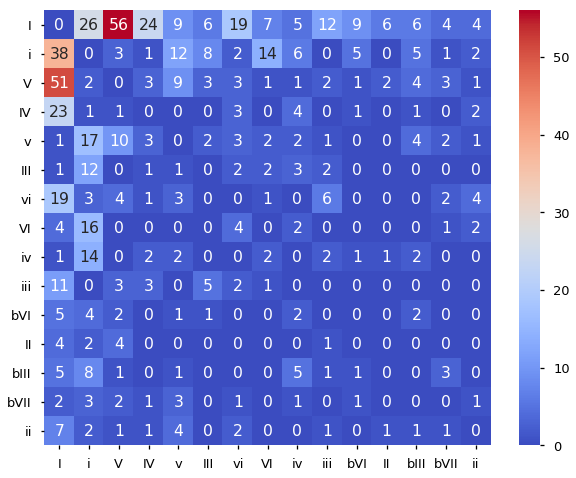

In [42]:
plt.figure(figsize=(10,8))
sns.heatmap(key_bigram_counts.iloc[:15,:15], 
            cmap='coolwarm', 
            annot=True, 
            fmt='.0f',
           )

plt.yticks(rotation=0);
plt.savefig('img/key_bigrams_norep.png')

In [43]:
normalized_key_bigrams = key_bigram_counts.div(key_bigram_counts.sum(axis=0), axis=1)
normalized_key_bigrams.head()

,I,i,V,IV,v,III,vi,VI,iv,iii,...,bv,#ii,bii,#II,bI,#IV,a,Ab,bi,#v
I,0.000000,0.216667,0.629213,0.600,0.183673,0.24,0.413043,0.21875,0.125,0.363636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
i,0.206522,0.000000,0.033708,0.025,0.244898,0.32,0.043478,0.43750,0.150,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
V,0.277174,0.016667,0.000000,0.075,0.183673,0.12,0.065217,0.03125,0.025,0.060606,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
IV,0.125000,0.008333,0.011236,0.000,0.000000,0.00,0.065217,0.00000,0.100,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
v,0.005435,0.141667,0.112360,0.075,0.000000,0.08,0.065217,0.06250,0.050,0.030303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.3 Proportions of local keys per movement

In [55]:
movements = []

for index, group in grouped:
    movements.append(group['local_key'].values)

In [56]:
df.local_key.unique()

array(['I', 'vi', 'iii', 'ii', 'V', '#V', 'IV', '#iii', '#I', 'bVII', 'i',
       'bIII', 'v', 'VI', 'II', '#iv', 'bVI', 'III', 'iv', '#i', 'vii',
       'VII', 'biii', 'bII', 'bV', 'a', '#vii', '#II', '#III', 'bvii',
       'Ab', '#ii', '#IV', '#v', 'bI', 'bIV', 'bi', 'bv', 'bii', '#VI'],
      dtype=object)

In [61]:
N = len(df.local_key.unique())
arr = np.arange(N)
np.random.shuffle(arr)
arr

array([32, 14, 30, 36,  1, 25,  6, 13, 15, 17, 28, 22, 37,  7,  4, 21, 33,
       12, 34, 27, 18, 39, 19, 29,  2, 38,  0, 10,  3, 24, 31, 23,  5, 20,
       35,  9, 16,  8, 26, 11])

In [62]:
d = dict(zip(arr, df.local_key.unique()))
d = {v:k for k,v in d.items()}

In [63]:
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

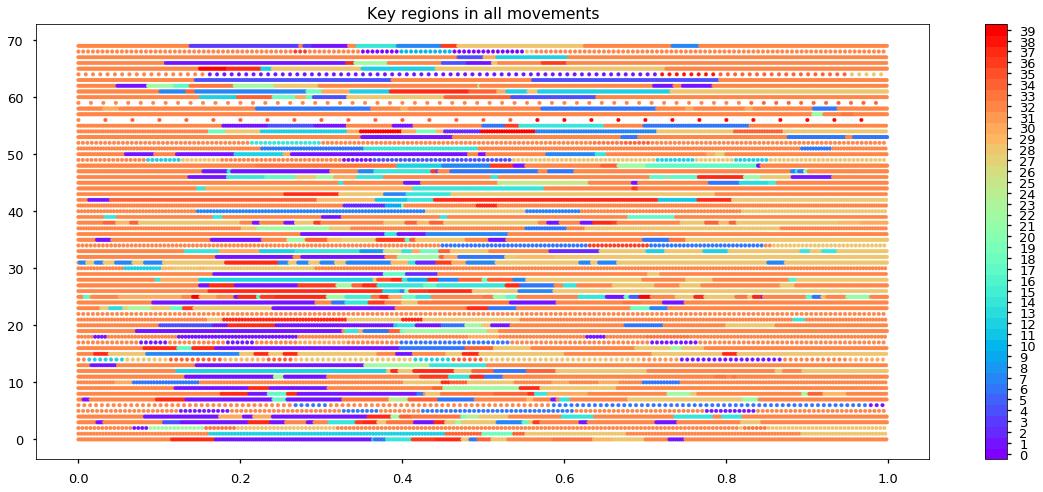

In [64]:
plt.figure(figsize=(20,8))

for i, mov in enumerate(movements):
    x = np.arange(len(mov)) /len(mov)
    y = [i]*len(mov)
    c = arr
    
    l = np.array([d[chord] for chord in mov])

    plt.scatter(x, y, c=l, s=50, marker='.', cmap=discrete_cmap(N, 'rainbow'))
    plt.clim(-0.5, N - 0.5)
plt.title('Key regions in all movements')
plt.colorbar(ticks=range(N))#.set_ticklabels(l)
plt.show()

### 2.4 Modulation probabilities
From http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

In [69]:
top = 8
reduced = key_bigram_counts.iloc[:top,:top].div(key_bigram_counts.iloc[:top,:top].sum(axis=1), axis=0).round(2)
reduced

,I,i,V,IV,v,III,vi,VI
I,0.00,0.18,0.38,0.16,0.06,0.04,0.13,0.05
i,0.49,0.00,0.04,0.01,0.15,0.10,0.03,0.18
V,0.71,0.03,0.00,0.04,0.12,0.04,0.04,0.01
IV,0.82,0.04,0.04,0.00,0.00,0.00,0.11,0.00
v,0.03,0.45,0.26,0.08,0.00,0.05,0.08,0.05
III,0.05,0.63,0.00,0.05,0.05,0.00,0.11,0.11
vi,0.61,0.10,0.13,0.03,0.10,0.00,0.00,0.03
VI,0.17,0.67,0.00,0.00,0.00,0.00,0.17,0.00


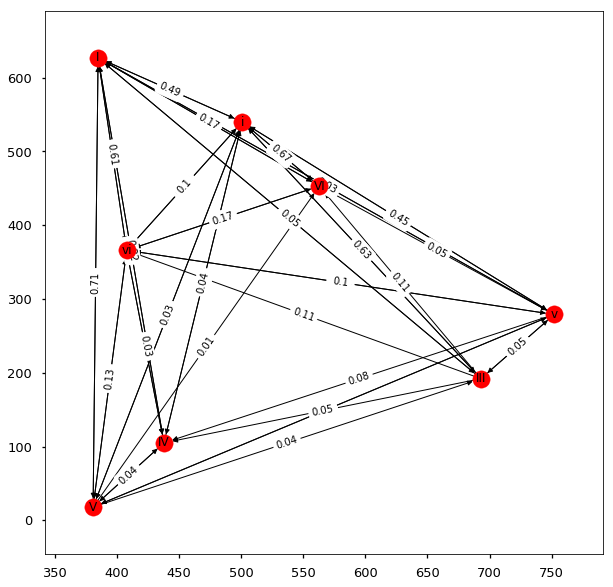

In [70]:
state_space = keys[:top]
# create transition matrix
# equals transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

states = state_space.index
q = reduced

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(reduced)

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

plt.figure(figsize=(10,10))

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)

# edges represent transition probabilities
for k, v in edges_wts.items():
    if v != 0.0:
        origin, destination = k[0], k[1]
        G.add_edge(origin, destination, 
                   length=1-v, 
                   label=v, 
                   penwidth=10*v)
# print(f'Edges:')
# pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
dot = nx.drawing.nx_pydot.write_dot(G, 'img/reduced.dot')

In [72]:
from graphviz import Source
temp = """
digraph  {
rankdir=LR;
    size="20"
node [shape = circle];

I;
i;
V;
IV;
v;
III;
vi;
VI;
I -> i  [key=0, length="0.8200000000000001", label="0.18", penwidth="1.7999999999999998"];
I -> V  [key=0, length="0.62", label="0.38", penwidth="3.8"];
I -> IV  [key=0, length="0.84", label="0.16", penwidth="1.6"];
I -> v  [key=0, length="0.94", label="0.06", penwidth="0.6"];
I -> III  [key=0, length="0.96", label="0.04", penwidth="0.4"];
I -> vi  [key=0, length="0.87", label="0.13", penwidth="1.3"];
I -> VI  [key=0, length="0.95", label="0.05", penwidth="0.5"];
i -> I  [key=0, length="0.51", label="0.49", penwidth="4.9"];
i -> V  [key=0, length="0.96", label="0.04", penwidth="0.4"];
i -> IV  [key=0, length="0.99", label="0.01", penwidth="0.1"];
i -> v  [key=0, length="0.85", label="0.15", penwidth="1.5"];
i -> III  [key=0, length="0.9", label="0.1", penwidth="1.0"];
i -> vi  [key=0, length="0.97", label="0.03", penwidth="0.3"];
i -> VI  [key=0, length="0.8200000000000001", label="0.18", penwidth="1.7999999999999998"];
V -> I  [key=0, length="0.29000000000000004", label="0.71", penwidth="7.1"];
V -> i  [key=0, length="0.97", label="0.03", penwidth="0.3"];
V -> IV  [key=0, length="0.96", label="0.04", penwidth="0.4"];
V -> v  [key=0, length="0.88", label="0.12", penwidth="1.2"];
V -> III  [key=0, length="0.96", label="0.04", penwidth="0.4"];
V -> vi  [key=0, length="0.96", label="0.04", penwidth="0.4"];
V -> VI  [key=0, length="0.99", label="0.01", penwidth="0.1"];
IV -> I  [key=0, length="0.18000000000000005", label="0.82", penwidth="8.2"];
IV -> i  [key=0, length="0.96", label="0.04", penwidth="0.4"];
IV -> V  [key=0, length="0.96", label="0.04", penwidth="0.4"];
IV -> vi  [key=0, length="0.89", label="0.11", penwidth="1.1"];
v -> I  [key=0, length="0.97", label="0.03", penwidth="0.3"];
v -> i  [key=0, length="0.55", label="0.45", penwidth="4.5"];
v -> V  [key=0, length="0.74", label="0.26", penwidth="2.6"];
v -> IV  [key=0, length="0.92", label="0.08", penwidth="0.8"];
v -> III  [key=0, length="0.95", label="0.05", penwidth="0.5"];
v -> vi  [key=0, length="0.92", label="0.08", penwidth="0.8"];
v -> VI  [key=0, length="0.95", label="0.05", penwidth="0.5"];
III -> I  [key=0, length="0.95", label="0.05", penwidth="0.5"];
III -> i  [key=0, length="0.37", label="0.63", penwidth="6.3"];
III -> IV  [key=0, length="0.95", label="0.05", penwidth="0.5"];
III -> v  [key=0, length="0.95", label="0.05", penwidth="0.5"];
III -> vi  [key=0, length="0.89", label="0.11", penwidth="1.1"];
III -> VI  [key=0, length="0.89", label="0.11", penwidth="1.1"];
vi -> I  [key=0, length="0.39", label="0.61", penwidth="6.1"];
vi -> i  [key=0, length="0.9", label="0.1", penwidth="1.0"];
vi -> V  [key=0, length="0.87", label="0.13", penwidth="1.3"];
vi -> IV  [key=0, length="0.97", label="0.03", penwidth="0.3"];
vi -> v  [key=0, length="0.9", label="0.1", penwidth="1.0"];
vi -> VI  [key=0, length="0.97", label="0.03", penwidth="0.3"];
VI -> I  [key=0, length="0.83", label="0.17", penwidth="1.7000000000000002"];
VI -> i  [key=0, length="0.32999999999999996", label="0.67", penwidth="6.7"];
VI -> vi  [key=0, length="0.83", label="0.17", penwidth="1.7000000000000002"];
}

"""

s = Source(temp, filename="img/modulation_probs", format="svg")
s.view()

'img/modulation_probs.svg'

![M](img/modulation_probs.svg)